# Simulation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
from scipy.sparse import csr_matrix

In [3]:
import celloracle as co
%matplotlib inline

In [4]:
#plt.rcParams["figure.figsize"] = [9,6]
#%config InlineBackend.figure_format = 'retina'
#plt.rcParams["savefig.dpi"] = 600

In [5]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

Load data from previous notebook.

In [6]:
#load oracle object
oracle = co.load_hdf5("./Pancreas_data.celloracle.oracle")

In [7]:
#load GRNs, which were saved in the Links obect
links = co.load_hdf5("./links.celloracle.links")

# 2. Make predictive models for simulation

We will fit ridge regression models again (after feature selection using p-values).
This process takes less time than the GRN inference in the previous notebook because we only use significant TFs to predict target gene instead of all regulatory candidate TFs. 

In [8]:
#filter based on the p-value 0.001 default
links.filter_links()

In [9]:
#extract TF and target gene info from links object
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [10]:
#fit GRN
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in Alpha


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 981 genes
calculating GRN in Beta


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 972 genes
calculating GRN in Delta


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 859 genes
calculating GRN in Ductal


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 819 genes
calculating GRN in Epsilon


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 770 genes
calculating GRN in Ngn3 high EP


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 951 genes
calculating GRN in Ngn3 low EP


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 799 genes
calculating GRN in Pre-endocrine


  0%|          | 0/2000 [00:00<?, ?it/s]

genes_in_gem: 2000
models made for 1013 genes


## 3. Velocity

In [11]:
scv.tl.recover_dynamics(oracle.adata, n_jobs = 14)

recovering dynamics (using 14/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:02:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [12]:
#compute velocities
scv.tl.velocity(oracle.adata, mode='dynamical')

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
scv.tl.velocity_graph(oracle.adata)

computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [14]:
#scv.pl.velocity_embedding_stream(oracle.adata, basis='umap')

## 4. Latent time

In [15]:
scv.tl.latent_time(oracle.adata)
#scv.pl.scatter(oracle.adata, color='latent_time', color_map='gnuplot', size=80)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [16]:
top_genes = oracle.adata.var['fit_likelihood'].sort_values(ascending=False).index#[:300]
#scv.pl.heatmap(oracle.adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [17]:
scv.tl.rank_dynamical_genes(oracle.adata, groupby='clusters')

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


In [18]:
# Save oracle object.
#oracle.to_hdf5("Pancreas_grn_vel.celloracle.oracle")

In [19]:
oracle.adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'rank_dynamical_genes'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    

## 5. Crazy Ideas

Propagate GRN signal using only TFs.

In [20]:
#load oracle object
#oracle = co.load_hdf5("./Pancreas_grn_vel.celloracle.oracle")

In [21]:
from simulation import signal_prop

In [22]:
grn = signal_prop(oracle)
oracle.adata.layers['grn'] = grn.copy()

In [23]:
scv.tl.velocity_graph(oracle.adata, vkey='grn')

computing velocity graph
    finished (0:00:09) --> added 
    'grn_graph', sparse matrix with cosine correlations (adata.uns)


In [24]:
scv.tl.velocity_embedding(oracle.adata, vkey = 'grn')

computing velocity embedding
    finished (0:00:00) --> added
    'grn_umap', embedded velocity vectors (adata.obsm)


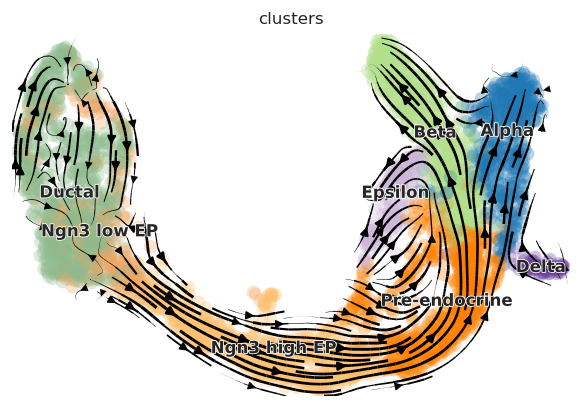

In [25]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='grn', dpi=120)#, save='stream_grn_change_tfs.png')

In [26]:
#using only target genesscv.tl.velocity_embedding(oracle.adata, vkey = 'grn')scv.tl.velocity_embedding(oracle.adata, vkey = 'grn')
grn.loc[:,oracle.adata.to_df().columns.isin(oracle.active_regulatory_genes)] = np.nan
oracle.adata.layers['grn_no_tfs'] = grn

In [27]:
scv.tl.velocity_graph(oracle.adata, vkey='grn_no_tfs')

computing velocity graph
    finished (0:00:08) --> added 
    'grn_no_tfs_graph', sparse matrix with cosine correlations (adata.uns)


In [28]:
scv.tl.velocity_embedding(oracle.adata, vkey = 'grn_no_tfs')

computing velocity embedding
    finished (0:00:00) --> added
    'grn_no_tfs_umap', embedded velocity vectors (adata.obsm)


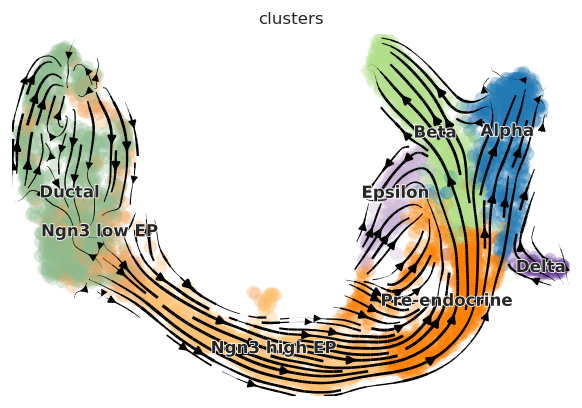

In [29]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='grn_no_tfs', dpi=120)#, save='stream_grn_change_tfs.png')

In [30]:
grn = signal_prop(oracle)
grn.loc[:,~oracle.adata.to_df().columns.isin(oracle.active_regulatory_genes)] = np.nan
oracle.adata.layers['grn_tfs'] = grn

In [59]:
scv.tl.velocity_graph(oracle.adata, vkey='grn_tfs')

KeyError: 'mode'

In [32]:
scv.tl.velocity_embedding(oracle.adata, vkey = 'grn_tfs')

computing velocity embedding
    finished (0:00:00) --> added
    'grn_tfs_umap', embedded velocity vectors (adata.obsm)


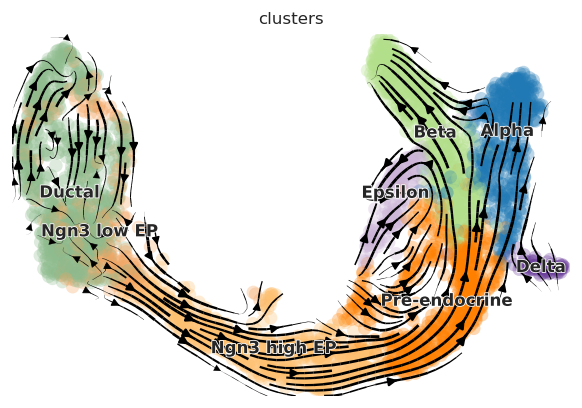

In [33]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='grn_tfs', dpi=120)#, save='stream_grn_change_tfs.png')

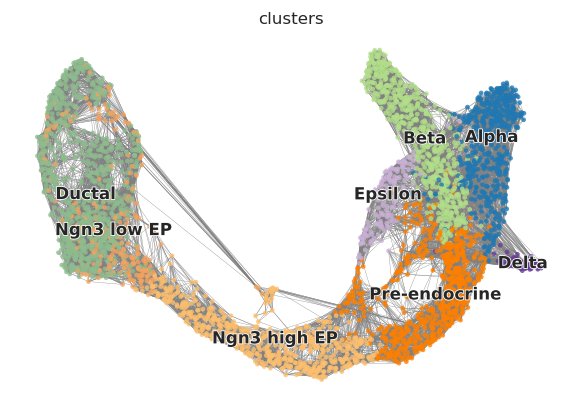

In [34]:
scv.pl.velocity_graph(oracle.adata, threshold=.1, vkey='grn_tfs', dpi=120)#, save='graph_grn_change_tfs.png')

In [44]:
top_genes = oracle.adata.var['fit_likelihood'].sort_values(ascending=False).index
velocity_df = oracle.adata.to_df('velocity')
velocity_df.loc[:,~velocity_df.columns.isin(top_genes[:30].values)] = np.nan

oracle.adata.layers['velocity_top30'] = velocity_df

In [60]:
scv.tl.velocity_graph(oracle.adata, vkey='velocity_top30')

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_top30_graph', sparse matrix with cosine correlations (adata.uns)


In [61]:
scv.tl.velocity_embedding(oracle.adata, vkey ='velocity_top30')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_top30_umap', embedded velocity vectors (adata.obsm)


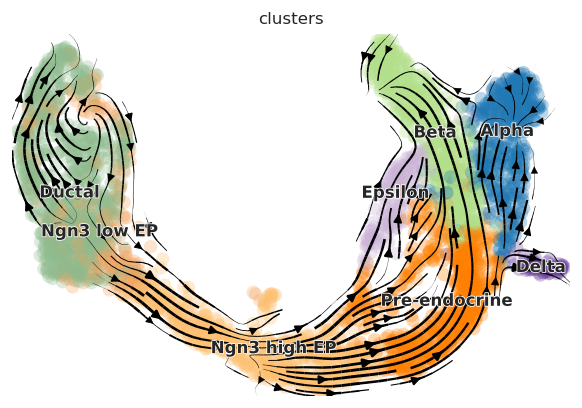

In [62]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='velocity_top30', dpi=120)#, save='stream_grn_change_tfs.png')

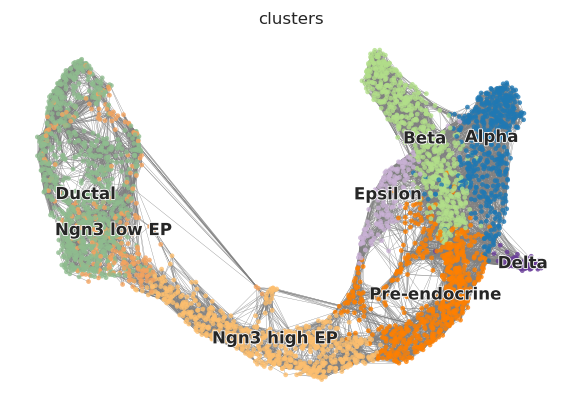

In [69]:
scv.pl.velocity_graph(oracle.adata, threshold=.1, vkey='velocity_top30', dpi=120)#, save='graph_grn_change_tfs.png')

In [36]:
TM_grn1 = transition_matrix(oracle.adata, vkey = 'grn')
TM_grn1 = pd.DataFrame(TM_grn1.toarray(), columns = oracle.adata.obs.index.values, index=oracle.adata.obs.index.values)

In [37]:
gem_future1 = TM_grn1.dot(gem_imputed)

In [38]:
oracle.adata.layers['gem_future'] = gem_future1

In [39]:
simulation_input = gem_future1.copy()
n_propagation = 1

In [40]:
simulated = []

In [41]:
#just use TFs for the simulation
simulation_input.loc[:,~gem_future.columns.isin(oracle.active_regulatory_genes)] = gem_imputed.loc[:,~gem_future.columns.isin(oracle.active_regulatory_genes)]

In [50]:
for cluster in np.unique(cluster_info):
    
    simulation_input_ = simulation_input[cluster_info == cluster] #future value of transcription factors
    gem_ = gem_imputed[cluster_info == cluster] #expression matrix
    
    #####    
    simulation_input.loc[:,~simulation_input.columns.isin(target_genes[cluster])] = gem_imputed.loc[:,~simulation_input.columns.isin(target_genes[cluster])]   
    #####
    
    coef_matrix = oracle.coef_matrix_per_cluster[cluster] #coefficient matrix
    
    delta_input = simulation_input_ - gem_ #difference in TF expression (from t1 to t0), the other genes are zero

    delta_simulated = delta_input.copy() 
    
    for i in range(n_propagation):
        delta_simulated = delta_simulated.dot(coef_matrix) #propagate the difference in expression of TFs using the coefficients
        #delta_simulated[delta_input != 0] = delta_input #do not predict transcription factor expression

        # gene expression cannot be negative. adjust delta values to make sure that gene expression are not negative values.
        gem_tmp = gem_ + delta_simulated #add the change in expression of other genes, to obtain their future value
        gem_tmp[gem_tmp<0] = 0 #do not allow negative counts
        delta_simulated = gem_tmp - gem_ #new difference in expression 

    gem_simulated = gem_ + delta_simulated #add the difference in expression to obtain the future value
    
    simulated_in_the_cluster = gem_simulated 
    
    simulated.append(simulated_in_the_cluster)
        
gem_simulated = pd.concat(simulated, axis=0)
gem_simulated = gem_simulated.reindex(gem_imputed.index)

In [51]:
oracle.adata.layers['simulated_count1'] = gem_simulated

In [52]:
oracle.adata.layers['grn1'] = gem_simulated - gem_imputed

In [53]:
scv.tl.velocity_graph(oracle.adata, vkey='grn1')

computing velocity graph
    finished (0:00:09) --> added 
    'grn1_graph', sparse matrix with cosine correlations (adata.uns)


In [54]:
scv.tl.velocity_embedding(oracle.adata, vkey = 'grn1')

computing velocity embedding
    finished (0:00:00) --> added
    'grn1_umap', embedded velocity vectors (adata.obsm)


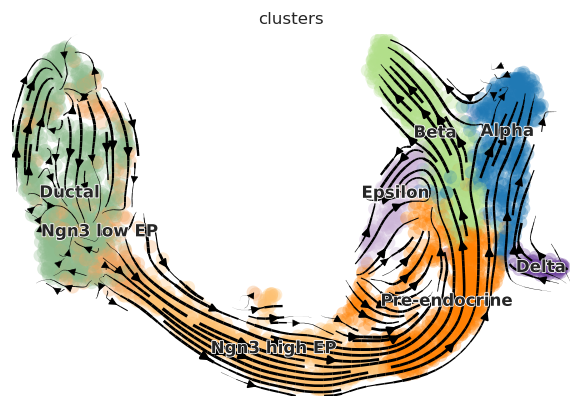

In [55]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='grn1', dpi=120)#, save='stream_grn_change_tfs.png')

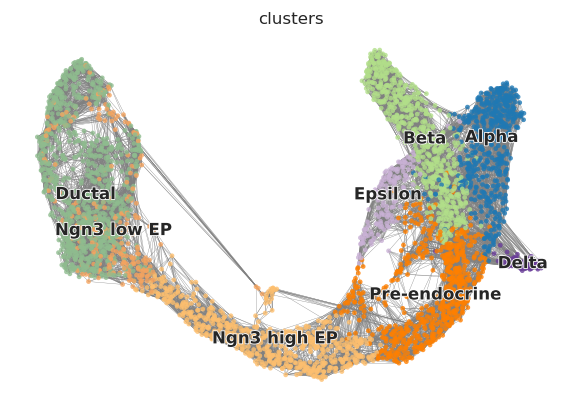

In [56]:
scv.pl.velocity_graph(oracle.adata, threshold=.1, vkey='grn1', dpi=120)#, save='graph_grn_change_tfs.png')

In [57]:
TM_grn2 = transition_matrix(oracle.adata, vkey = 'grn1')
TM_grn2 = pd.DataFrame(TM_grn2.toarray(), columns = oracle.adata.obs.index.values, index=oracle.adata.obs.index.values)

In [58]:
gem_future2 = TM_grn2.dot(gem_imputed)

In [59]:
oracle.adata.layers['gem_future'] = gem_future2

In [60]:
simulation_input = gem_future2.copy()
n_propagation = 1

In [61]:
simulated = []

In [62]:
#just use TFs for the simulation
simulation_input.loc[:,~gem_future.columns.isin(oracle.active_regulatory_genes)] = gem_imputed.loc[:,~gem_future.columns.isin(oracle.active_regulatory_genes)]

In [63]:
for cluster in np.unique(cluster_info):
    
    simulation_input_ = simulation_input[cluster_info == cluster] #future value of transcription factors
    gem_ = gem_imputed[cluster_info == cluster] #expression matrix
    
    #####    
    simulation_input.loc[:,~simulation_input.columns.isin(target_genes[cluster])] = gem_imputed.loc[:,~simulation_input.columns.isin(target_genes[cluster])]   
    #####
    
    coef_matrix = oracle.coef_matrix_per_cluster[cluster] #coefficient matrix
    
    delta_input = simulation_input_ - gem_ #difference in TF expression (from t1 to t0), the other genes are zero

    delta_simulated = delta_input.copy() 
    
    for i in range(n_propagation):
        delta_simulated = delta_simulated.dot(coef_matrix) #propagate the difference in expression of TFs using the coefficients
        #delta_simulated[delta_input != 0] = delta_input #do not predict transcription factor expression

        # gene expression cannot be negative. adjust delta values to make sure that gene expression are not negative values.
        gem_tmp = gem_ + delta_simulated #add the change in expression of other genes, to obtain their future value
        gem_tmp[gem_tmp<0] = 0 #do not allow negative counts
        delta_simulated = gem_tmp - gem_ #new difference in expression 

    gem_simulated = gem_ + delta_simulated #add the difference in expression to obtain the future value
    
    simulated_in_the_cluster = gem_simulated 
    
    simulated.append(simulated_in_the_cluster)
        
gem_simulated = pd.concat(simulated, axis=0)
gem_simulated = gem_simulated.reindex(gem_imputed.index)

In [64]:
oracle.adata.layers['simulated_count2'] = gem_simulated

In [65]:
oracle.adata.layers['grn2'] = gem_simulated - gem_imputed

In [66]:
scv.tl.velocity_graph(oracle.adata, vkey='grn2')

computing velocity graph
    finished (0:00:09) --> added 
    'grn2_graph', sparse matrix with cosine correlations (adata.uns)


In [67]:
scv.tl.velocity_embedding(oracle.adata, vkey = 'grn2')

computing velocity embedding
    finished (0:00:00) --> added
    'grn2_umap', embedded velocity vectors (adata.obsm)


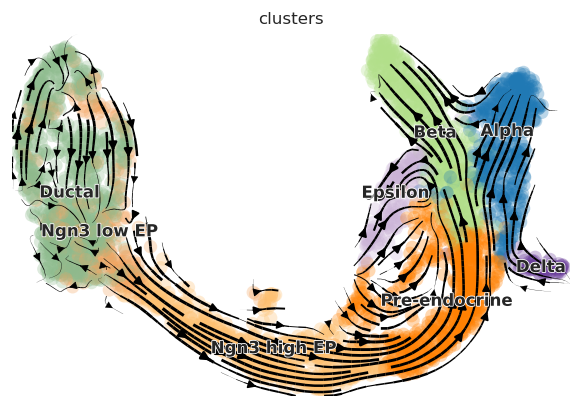

In [68]:
scv.pl.velocity_embedding_stream(oracle.adata, vkey='grn2', dpi=120)#, save='stream_grn_change_tfs.png')

try just with target genes.
try another network as well to reconstruct the displacements.

saving figure to file ./figures/scvelo_trajectory70.png


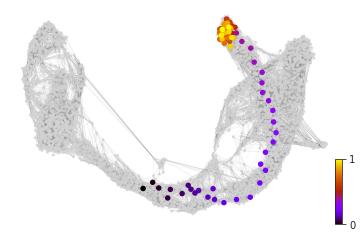

In [41]:
x, y = scv.utils.get_cell_transitions(oracle.adata, basis='umap', starting_cell=70, vkey='grn', random_state = 27)
ax = scv.pl.velocity_graph(oracle.adata, c='lightgrey', edge_width=.05, show=False, vkey='grn')
ax = scv.pl.scatter(oracle.adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, vkey='grn', save='trajectory70.png')

saving figure to file ./figures/scvelo_trajectory190.png


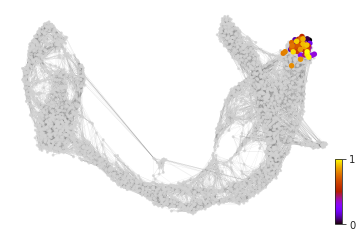

In [42]:
x, y = scv.utils.get_cell_transitions(oracle.adata, basis='umap', starting_cell=190, vkey='grn', random_state = 27)
ax = scv.pl.velocity_graph(oracle.adata, c='lightgrey', edge_width=.05, show=False, vkey='grn')
ax = scv.pl.scatter(oracle.adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, vkey='grn', save='trajectory190.png')

saving figure to file ./figures/scvelo_trajectory2152.png


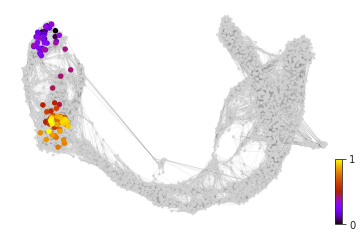

In [81]:
x, y = scv.utils.get_cell_transitions(oracle.adata, basis='umap', starting_cell=2152, vkey='grn', random_state = 27)
ax = scv.pl.velocity_graph(oracle.adata, c='lightgrey', edge_width=.05, show=False, vkey='grn')
ax = scv.pl.scatter(oracle.adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, vkey='grn', save='trajectory2152.png')

saving figure to file ./figures/scvelo_trajectory3350.png


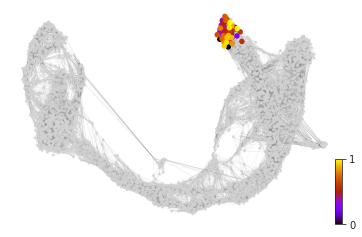

In [82]:
x, y = scv.utils.get_cell_transitions(oracle.adata, basis='umap', starting_cell=3350, vkey='grn', random_state = 27)
ax = scv.pl.velocity_graph(oracle.adata, c='lightgrey', edge_width=.05, show=False, vkey='grn')
ax = scv.pl.scatter(oracle.adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax, vkey='grn', save='trajectory3350.png')

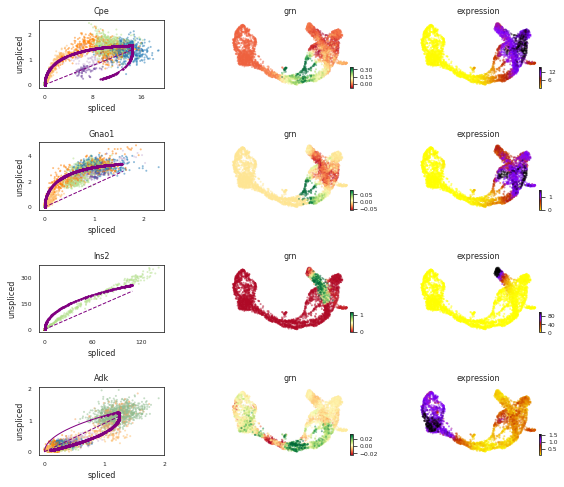

In [83]:
scv.pl.velocity(oracle.adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=1, vkey= 'grn')

## 4. Sankey diagram and trajectories

In [84]:
from celloracle.trajectory.sankey import sankey
from celloracle.trajectory.oracle_core import _deal_with_na
from celloracle.trajectory.oracle_utility import _adata_to_color_dict

from scvelo.tools.transition_matrix import transition_matrix

In [85]:
#initial parameters for simulation (USER INPUT)
n_steps=10
n_duplication = 3
n_neighbors = 30

In [86]:
#prepare the indices
n_cells = oracle.adata.X.shape[0]
start_cell_id_array = np.repeat(np.arange(n_cells), n_duplication)

#prepare transition matrix
tr_matrix = transition_matrix(oracle.adata, vkey='grn')
transition_prob = _deal_with_na(tr_matrix.toarray())
T = csr_matrix(transition_prob)
T.indices = tr_matrix.indices
T.indptr = tr_matrix.indptr

In [87]:
np.random.seed(1)
#compute trajectories
transitions = []
for i in start_cell_id_array:
    X = [i]
    for _ in range (n_steps):
        t = T[X[-1]]
        indices, p = t.indices, t.data
        idx = np.argsort(t.data)[::-1][:n_neighbors]
        indices, p = indices[idx], p[idx]
        p /=np.sum(p)
        ix = np.random.choice(indices, p = p)
        X.append(ix)
    transitions.append(X)
    
#results:
trajectory_df = pd.DataFrame(transitions)
trajectory_df.index = trajectory_df[0]

In [88]:
#prepare data for sankey diagram
mcmc_transition_cluster = pd.DataFrame(np.array(oracle.adata.obs['clusters'])[trajectory_df.values])
mcmc_color_dict = _adata_to_color_dict(oracle.adata, 'clusters')
df = mcmc_transition_cluster.iloc[:, [0, -1]]
df.columns = ["start", "end"]
order = ['Ductal','Ngn3 low EP', 'Ngn3 high EP','Pre-endocrine',
         'Delta','Epsilon','Alpha','Beta']

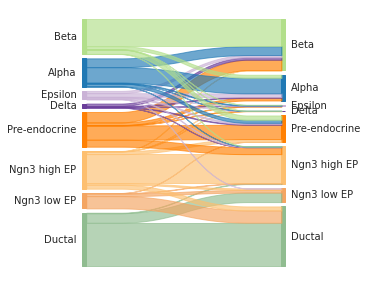

In [89]:
#sankey diagram
plt.figure(figsize=[4, 5])
sankey(left=df['start'], right=df['end'],
               aspect=1, fontsize=10,
               colorDict=mcmc_color_dict,
               leftLabels=order, rightLabels=order)

In [90]:
np.round((df['start'].value_counts()/(3696*3))*100,2)

Ductal           24.78
Ngn3 high EP     17.37
Pre-endocrine    16.02
Beta             15.99
Alpha            13.01
Ngn3 low EP       7.09
Epsilon           3.84
Delta             1.89
Name: start, dtype: float64

In [91]:
np.round((df['end'].value_counts()/(3696*3))*100,2)

Ductal           27.70
Beta             23.57
Ngn3 high EP     17.45
Pre-endocrine    12.21
Alpha            11.88
Ngn3 low EP       6.30
Epsilon           0.72
Delta             0.17
Name: end, dtype: float64

In [92]:
start_df = pd.DataFrame(data=np.round((df['start'].value_counts()/(3696*3))*100,2))

In [93]:
start_df.to_csv('./grn_vs_velocity/start_df.csv')

In [94]:
end_df = pd.DataFrame(data=np.round((df['end'].value_counts()/(3696*3))*100,2))

In [95]:
end_df.to_csv('./grn_vs_velocity/end_df_clipping_100.csv')

In [96]:
def _plot_one_trajectory(adata, trajectory_df, cell_ix_in_mcmctid, time_range, args={}, embedding = 'X_umap'):
        tt = trajectory_df.iloc[cell_ix_in_mcmctid,:].values[time_range]
        plt.plot(adata.obsm[embedding][:,0][tt], adata.obsm[embedding][:,1][tt], **args)

In [97]:
#plot trajectories
def plot_mc_result_as_trajectory(adata, trajectory_df, cell_name, time_range, args={}, embedding = 'X_umap'):
        """
        Pick up several timepoints in the cell state-transition simulation and plot as a line plot.
        This function can be used to visualize how cell-state changes after perturbation focusing on a specific cell.
        Args:
            cell_name (str): cell name. chose from adata.obs.index
            time_range (list of int): the list of index in Markov simulation
            args (dictionary): dictionary for the arguments for matplotlib.pyplit.plot.
                See matplotlib documentation for details (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot).
        """
        cell_ix = np.where(adata.obs.index == cell_name)[0][0]
        cell_ix_in_mcmctid = np.where(trajectory_df.index == cell_ix)[0]

        # plot all cells in gray color
        plt.scatter(adata.obsm[embedding][:,0], adata.obsm[embedding][:,1], s=1, c="lightgray")


        for i in cell_ix_in_mcmctid:
            _plot_one_trajectory(adata, trajectory_df, i, time_range, args)

        # plot cell of interest (initiation point of simulation) in red color
        plt.scatter(adata.obsm[embedding][cell_ix,0], adata.obsm[embedding][cell_ix,1], s=50, c="red")

cell AACCGCGAGGATGGTC


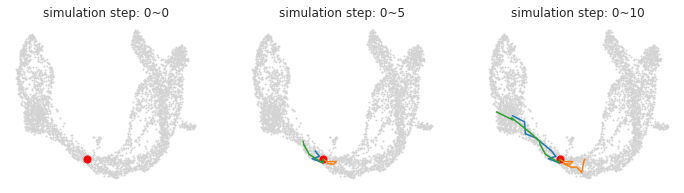

cell ACACCAAGTATAATGG


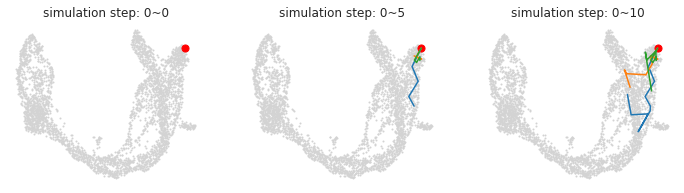

cell GATCGCGAGCTGAACG


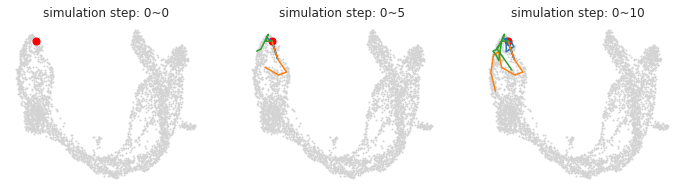

cell TGCCCATGTGCCTGGT


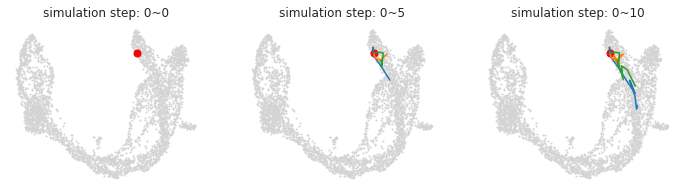

In [98]:
# Randomly pick up cells
np.random.seed(1)
cells = oracle.adata.obs.index.values[[70,190, 2152, 3350]]

# Visualize the simulated results of cell transition after perturbation
for k in cells:
    print(f"cell {k}")
    plt.figure(figsize=[12, 3])
    for j, i in enumerate([0, 5, 10]): # time points
        plt.subplot(1, 3, (j+1))
        plot_mc_result_as_trajectory(adata = oracle.adata, trajectory_df = trajectory_df, cell_name = k, time_range = range(0, i))
        plt.title(f"simulation step: 0~{i}")
        plt.axis("off")
    plt.show()

## GENES

### Differentially expressed genes

In [99]:
scv.tl.rank_velocity_genes(oracle.adata, groupby='clusters', min_corr=.3, vkey='grn')

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [100]:
df = scv.DataFrame(oracle.adata.uns['rank_velocity_genes']['names'])
df.head()

Ductal Ngn3 low EP Ngn3 high EP  Pre-endocrine    Beta   Alpha  \
0  Tmsb10      Rph3al        Igsf8         Camk2b  Pde10a   Mxra7   
1    Actb       Aplp2         Ctsf  1700086L19Rik   Mgat3   Mrpl1   
2    Cpt2      Rnf114     Serping1           Cd47    Maob    Ank2   
3  Eps8l2     Smarcd2        Drap1         Hspa4l  Atp2a2   Qsox1   
4   Aplp2     Stard10        Fxyd3           Rai2   Gfpt1  Tecpr1   

           Delta Epsilon  
0           Ell2     Cd9  
1         Zfp174   Aplp2  
2  2510009E07Rik    Cbfb  
3         Gatsl2  Eif2b2  
4          Bcl7a  Eps8l2

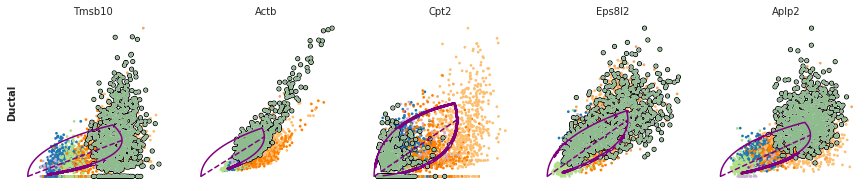

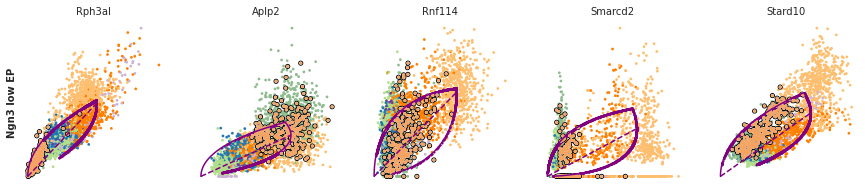

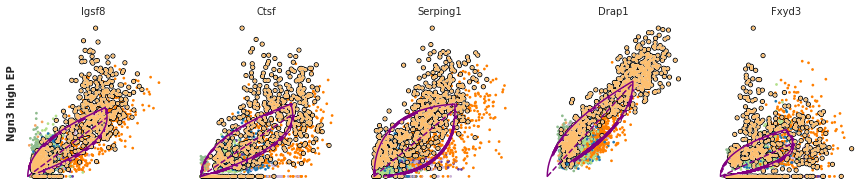

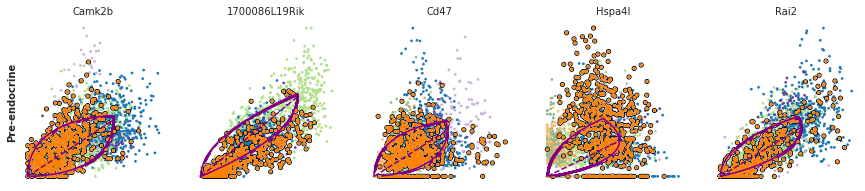

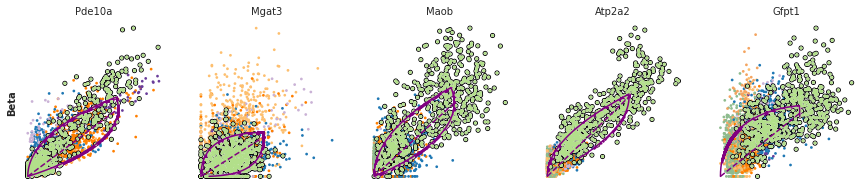

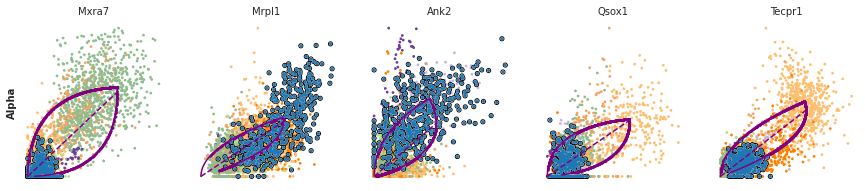

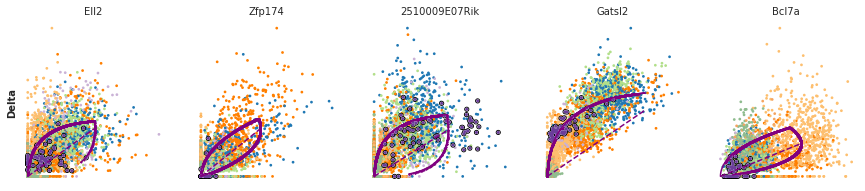

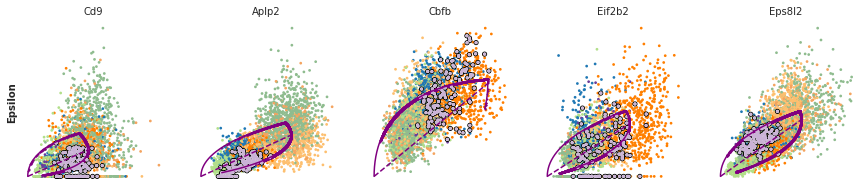

In [101]:
plt.rcParams["figure.figsize"] = [3,3]
kwargs = dict(frameon=False, size=30, linewidth=1.5)
for col in df.columns:
    scv.pl.scatter(oracle.adata, df[col][:5], ylabel=col, add_outline = col,**kwargs)

In [113]:
# Save oracle object.
oracle.to_hdf5("Pancreas_grn_sim.celloracle.oracle")

In [111]:
oracle.adata.layers['gem_future']

array([[2.07664757e-03, 1.53532270e-01, 8.78867910e-02, ...,
        1.50521909e-01, 1.50529860e-01, 2.18953832e-01],
       [0.00000000e+00, 4.51625056e-01, 5.77525832e-02, ...,
        1.48248389e-01, 2.10199123e-01, 2.28160645e-01],
       [8.59455687e-04, 1.05956096e-01, 7.82545643e-02, ...,
        1.39220612e-01, 1.03187080e-01, 2.16070571e-01],
       ...,
       [0.00000000e+00, 4.66562674e-01, 6.09260313e-02, ...,
        3.46061938e-02, 5.01674566e-02, 2.23194188e-01],
       [2.56497844e-06, 1.39151082e-01, 1.42268855e-01, ...,
        1.24813100e-01, 1.08971729e-01, 3.21047513e-01],
       [1.67125641e-03, 1.53714715e-01, 9.80381507e-02, ...,
        1.28758976e-01, 1.24562883e-01, 2.31202978e-01]])

In [112]:
oracle.adata.layers['simulated_count']

array([[0.        , 0.190102  , 0.11623952, ..., 0.15638133, 0.18107466,
        0.25907529],
       [0.        , 0.46511281, 0.05954748, ..., 0.21138673, 0.28347879,
        0.25280885],
       [0.        , 0.12079306, 0.07266118, ..., 0.11984905, 0.07251644,
        0.14282564],
       ...,
       [0.        , 0.50307848, 0.06224798, ..., 0.03162728, 0.03953122,
        0.22895148],
       [0.        , 0.16266481, 0.1234096 , ..., 0.13996265, 0.13429229,
        0.30314219],
       [0.        , 0.14602824, 0.06864913, ..., 0.1333245 , 0.10881785,
        0.27522892]])

Signature:
scv.tl.velocity_graph(
    data,
    vkey='velocity',
    xkey='Ms',
    tkey=None,
    basis=None,
    n_neighbors=None,
    n_recurse_neighbors=None,
    random_neighbors_at_max=None,
    sqrt_transform=None,
    variance_stabilization=None,
    gene_subset=None,
    compute_uncertainties=None,
    approx=None,
    mode_neighbors='distances',
    copy=False,
)
Docstring:
Computes velocity graph based on cosine similarities.

The cosine similarities are computed between velocities and potential cell state
transitions, i.e. it measures how well a corresponding change in gene expression
:math:`\delta_{ij} = x_j - x_i` matches the predicted change according to the
velocity vector :math:`\nu_i`,

.. math::
    \pi_{ij} = \cos\angle(\delta_{ij}, \nu_i)
    = \frac{\delta_{ij}^T \nu_i}{\left\lVert\delta_{ij}\right\rVert \left\lVert \nu_i \right\rVert}.

Arguments
---------
data: :class:`~anndata.AnnData`
    Annotated data matrix.
vkey: `str` (default: `'velocity'`)
    Name of v